## Error Mitigation for QNNs on IBM Devices

### Introduction

This tutorial demonstrates the setup and implementation of error mitigation techniques for Qiskit's primitives within the context of Quantum Neural Networks (QNNs) in sQUlearn. Firstly, we will train a small QNN using a noise-free and error-free simulator to fit a parabolic dataset. Subsequently, we will illustrate how to configure the `Executor` class to establish a connection with IBM Quantum devices. We assume that you have already set up an IBM account and have access to IBM Quantum devices. For detailed instructions on registering and configuring your IBM Quantum account, please refer to the following link: [IBM Quantum Account Management](https://qiskit.org/ecosystem/ibm-runtime/how_to/account-management.html).

Given the potentially lengthy queuing times for the free quantum devices, we will replicate the noise model of a quantum device and use the QASM simulator to emulate the real characteristics of a quantum computer. The simulator employed in this task, known as the `ibmq_qasm_simulator`, operates within the IBM Quantum cloud and can be accessed similarly to the actual quantum devices.

We will explore various error mitigation options for both the Estimator and Sampler primitives. Finally, we will demonstrate how to train the QNN on the quantum device (simulator) to adapt to noisy configurations and reduce finite sampling noise through variance regularization [1].

### Importing Libraries

The first step involves importing the necessary libraries for this tutorial. We will be using the `qiskit-ibm-runtime` package to establish connections with IBM Quantum devices and `qiskit-aer` to simulate the noise model of these quantum devices. Additionally, we will employ the `squlearn` library to configure and train the QNN on the quantum device.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam

### Set-up of the QNN

We first set-up the data encoding circuit of the QNN. Here we utilize the `ChebyshevPQC` encoding circuit for 2 qubits and 2 layers.

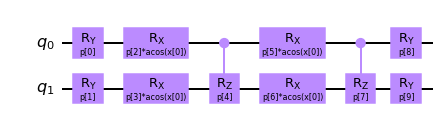

In [2]:
nqubits = 2
pqc = ChebyshevPQC(num_qubits=nqubits, num_features=1, num_layers=2)
pqc.draw("mpl")

We utilize the parameterized summation over Z Pauli matrices as the observable: $\hat{O} = \hat{I}\alpha + \sum_i\hat{Z}_i \beta_i$

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2])])


Lastly, we configure the Quantum Neural Network (QNN) using the QNNRegressor class sourced from the squlearn library. In this setup, we initialize the QNN with randomized weights, employ the L2 Loss (also known as SquaredLoss), and utilize the Adam optimization routine with a learning rate set to 0.1. It's noteworthy that during the training process, the QNN leverages the statevector_simulator to calculate the expectation values of observables, thereby ensuring a noise-free and error-free training environment.

In [4]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    Adam({"lr": 0.1}),
    param_ini,
    param_op_ini,
)

### Training of the QNN with a noise free simulator

In this cell, we set-up the data `x_train` and `y_train` for training the QNN. The values are obtained by calculating the values of the simple parametric function $f(x) = x^2$ with the `square` function of `numpy`.

In [5]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.square(x_train)

Afterwards, we train the QNN by calling the `fit` method of the `QNNRegressor` class.

In [6]:
qnn_simulator.fit(x_train, y_train)

fit: 100%|██████████| 100/100 [01:02<00:00,  1.67it/s]

The finial parameters of the encoding circuit and the observable are displayed in the output of the following cell.

In [7]:
print("Result encoding parameters:", qnn_simulator.param)
print("Result observable parameters:", qnn_simulator.param_op)

Result encoding parameters: [1.65135232 0.66524017 0.94685078 0.96012197 1.07676122 0.50876202
 0.97004195 0.64628971 0.84914015 0.66567045]
Result observable parameters: [0.94664274 0.41717632 0.89088529]


Following the QNN's training, we proceed to compute model inferences and visualize the results. The QNN model generates the parabolic output, affirming the successful training of the QNN.


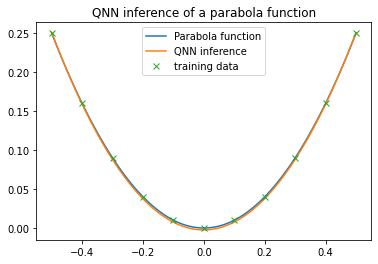

In [8]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

### Evaluating the QNN on the IBM backend with error mitigation

The subsequent phase involves assessing the noisy outcomes on the IBM backend by leveraging the Qiskit runtime environment. To mitigate queuing delays, we replicate the noise model of a physical quantum device and establish a QASM simulator that replicates its characteristics. To initiate the QiskitRuntimeService function, you must configure an access token outside this notebook. Throughout the execution of all interactions with the Qiskit runtime environment, a session is established that is linked to the QASM simulator backend of the IBM Quantum cloud.

In [9]:
# User token has to be set in advance file via save_account()
service = QiskitRuntimeService(channel="ibm_quantum")
# Copy the noise model of the backend
noisy_backend = service.get_backend("ibm_nairobi")
backend_noise_model = NoiseModel.from_backend(noisy_backend)
# Create a Session for the Qiskit primitives
session = Session(service, backend=service.get_backend("ibmq_qasm_simulator"))

In the upcoming cell, we configure the options for Qiskit primitives, specifying their usage of a noise model during evaluations. Furthermore, 10,000 shots are executed for each evaluation of the output of the QNN. 

In [10]:
options = Options()
options.simulator = {
    "noise_model": backend_noise_model,
    "coupling_map": noisy_backend.configuration().coupling_map,
    "basis_gates": noisy_backend.configuration().basis_gates,
}
options.execution.shots = 10000

Following that, we create an Executor containing an Estimator linked to the session we set up earlier. This configuration ensures that the QNN utilizes the Estimator Primitive for all its evaluations. Then, we proceed to create a new QNNRegressor, which is based on this updated Executor, and initialize it with the optimized set of parameters.

In [11]:
executor_backend = Executor(Estimator(session), caching=False)
qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_backend,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
)

#### Without error mitigation

In our first example, we turn off all error mitigation techniques and test the QNN on the IBM backend. We notice that the QNN's output differs noticeably from the output of the noise-free simulator.

The primary differences are that the QNN's output is no longer smooth; it shows zigzag patterns. This occurs because the QNN is evaluated with a limited number of shots, which introduces sampling noise to each QNN output. Additionally, the shape of the QNN function changes, as if an offset has been added. Upon closer examination, we can see that this offset is not constant.

The reason for these differences is that the applied gates are no longer perfect; they have some error rates that affect the QNN's shape. This issue can be significantly reduced by training the QNN on the same IBM backend where it is evaluated.

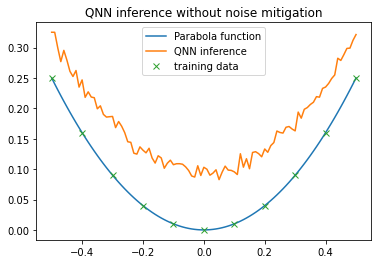

In [12]:
options.resilience_level = 0
options.optimization_level = 0

# Overwrites the options of the Estimator primitive
executor_backend.reset_options_estimator(options)

y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference without noise mitigation")
plt.show()

#### Dynamic decoupling and TREX error mitigation

In the following cell, we present the results obtained with Qiskit's default error mitigation setup. This setup is achieved by configuring the resilience level and optimization level in the primitive options to 1. For the estimator primitive, this translates to implementing dynamic decoupling for the circuits and employing TREX error mitigation for the expectation values. For more in-depth information on Qiskit error mitigation, please refer to [this link](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html).

Upon examination, we notice that the output's shape is now more closely aligned with that of the noise-free simulator. Nevertheless, it's important to mention that error mitigation leads to a slight increase in noise levels, which is also observable in the output.

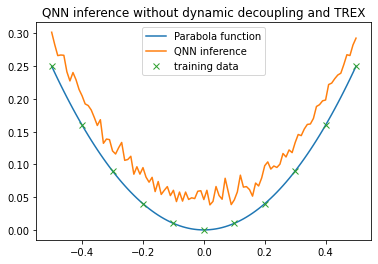

In [13]:
options.resilience_level = 1
options.optimization_level = 1

executor_backend.reset_options_estimator(options)

y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference without dynamic decoupling and TREX")
plt.show()

#### Dynamic decoupling and zero-noise extrapolation (ZNE) for error mitigation

In the last example using the Estimator primitive, we employed dynamic decoupling to mitigate circuit errors and zero-noise extrapolation (ZNE) for expectation value error mitigation. ZNE entails running quantum circuits with artificially increased noise levels and then extrapolating the results to a noise-free scenario.

Qiskit's zero-noise extrapolation implementation offers several options to fine-tune the error mitigation process. For detailed information on ZNE and advanced resilience options, please consult [this link](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html#advanced-resilience-options).

In this specific example, the ZNE did not completely align the QNN's output with the noise-free results, but the shape of the QNN's output is  closer to the noise-free simulator's output. However, the noise levels are significantly increased by the ZNE. 


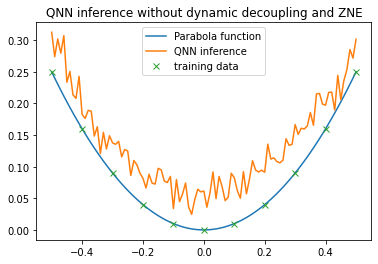

In [14]:
options.resilience_level = 2
options.optimization_level = 1
options.resilience.noise_factors = (1, 2, 3, 5)
options.resilience.noise_amplifier = "CxAmplifier"
options.resilience.extrapolator = "QuadraticExtrapolator"

executor_backend.reset_options_estimator(options)

y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference without dynamic decoupling and ZNE")
plt.show()

### Assessing the QNN on the IBM backend using the sampler primitive

In the forthcoming cells, we assess the QNN's performance by employing the Sampler primitive. The Sampler primitive gathers probabilities from the encoding circuits, the QNN then computes the expectation values of observables based on these probabilities. Consequently, the Sampler primitive provides distinct error mitigation options compared to the Estimator primitive.

In the subsequent cell, we reset the session and establish a fresh Executor that relies on the Sampler primitive. This setup ensures that the QNN utilizes the Sampler primitive for all its evaluations. Subsequently, we proceed to create a new QNNRegressor, rooted in this updated Executor, and initialize it with the optimized parameter set.

In [15]:
session = Session(service, backend=service.get_backend("ibmq_qasm_simulator"))
executor_backend = Executor(Sampler(session), caching=False)
qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_backend,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
)

#### Run the Sampler primitive without error mitigation

The following cell computes the inference with the Sampler primitive without error mitigation. Results are comparable to the Estimator primitive without error mitigation.

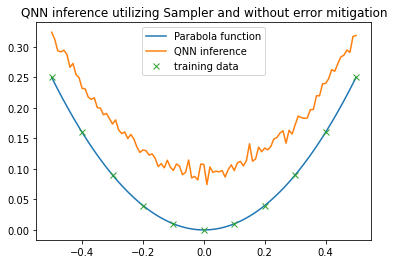

In [16]:
options.resilience_level = 0
options.optimization_level = 0

executor_backend.reset_options_sampler(options)

y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference utilizing Sampler and without error mitigation")
plt.show()

#### Run the Sampler primitive with dynamic decoupling and M3 error mitigation

The last inference calculation utilizes the dynamic decoupling for the circuits and employs the M3 error mitigation to mitigate readout errors. This is the default set-up for the Sampler primitive.

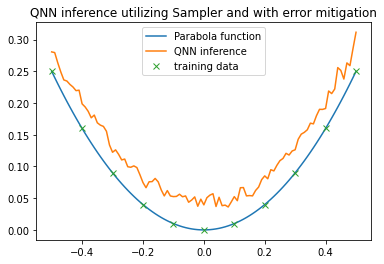

In [17]:
options.resilience_level = 1
options.optimization_level = 1

executor_backend.reset_options_sampler(options)

y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference utilizing Sampler and with error mitigation")
plt.show()

### Retraining the QNN on the IBM Backend without Error Mitigation using Variance Regularization

In the subsequent section, we illustrate the process of retraining the Quantum Neural Network (QNN) to achieve improved results on real quantum hardware. A crucial aspect of this approach is that we train the QNN on the same hardware on which it is subsequently evaluated.

Because the training process is capable of adapting to the hardware's imperfections, the need for error mitigation diminishes, allowing the final inference to align closely with real-world data. To address the noise stemming from finite sampling on real hardware, we employ variance regularization (as detailed in [1]). This regularization technique reduces the variance of the expectation value in addition to the L2 Loss, thereby ensuring a lower variance of the final inference.

In the initial step, we disable any error mitigation techniques. Throughout the optimization process, we utilize the ``Sampler`` primitive since it enables us to compute the additional expectation values needed for variance computation from the same set of circuits, eliminating the necessity for additional, costly circuit evaluations.

In [18]:
options.resilience_level = 0
options.optimization_level = 0
executor_backend.reset_options_estimator(options)

We reinitialize the QNNRegressor with an additional option aimed at reducing variance, which can be activated by adjusting the hyperparameter variance. This value serves as the pre-factor for the variance regularization term within the loss function. While recommended values typically fall within the range of 0.01 to 0.0001, the specific choice depends on the QNN's capacity to fit the data effectively.

It's important to note that this training process is time-intensive, primarily because it is executed on the IBM cloud infrastructure. The expectation time for the QNN training usually takes between 2 to 3 hours.

In [19]:
qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_backend,
    SquaredLoss(),
    Adam({"lr": 0.1}),
    param_ini,
    param_op_ini,
    variance=0.005,
)
qnn_backend.fit(x_train, y_train)

The final inference of the QNN aligns closely with the parabolic data, demonstrating the effectiveness of the QNN to adapt to the hardware's imperfections. Furthermore the noise stemming from finite sampling is significantly reduced.

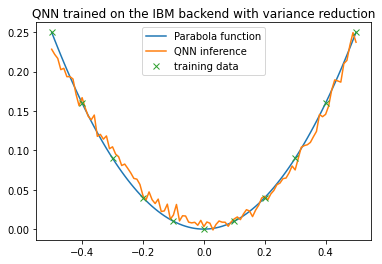

In [20]:
y = qnn_backend.predict(x)
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN trained on the IBM backend with variance reduction")
plt.show()

#### Literature:

[1]: David A. Kreplin, and Marco Roth. "Reduction of finite sampling noise in quantum neural networks." [arXiv preprint arXiv:2306.01639](https://arxiv.org/abs/2306.01639v2) (2023)